In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_eng = stopwords.words('english') + list(punctuation)

## Import Data

In [3]:
df = pd.read_csv('data/train_tweet.csv', index_col='id')
df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [5]:
df.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

## Dataset Splitting

In [6]:
X = df.text
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090,), (1523,), (6090,), (1523,))

## Training (SVM)

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
    ('prep', CountVectorizer(tokenizer=word_tokenize, stop_words=sw_eng)),
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

## Training (XGBoost)

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.feature_extraction.text import CountVectorizer

In [10]:
pipeline = Pipeline([
    ('prep', CountVectorizer(tokenizer=word_tokenize, stop_words=sw_eng)),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.9min finished
C:\Users\user\Miniconda3\envs\jcop_wv\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


{'algo__colsample_bytree': 0.9174392973699884, 'algo__gamma': 3, 'algo__learning_rate': 0.22983221528155043, 'algo__max_depth': 5, 'algo__n_estimators': 143, 'algo__reg_alpha': 0.061820520641258085, 'algo__reg_lambda': 0.16276924772060908, 'algo__subsample': 0.5963483619396968}
0.8343185550082102 0.7796411010152692 0.8049901510177282


## Evaluation

In [11]:
from jcopml.plot import plot_confusion_matrix

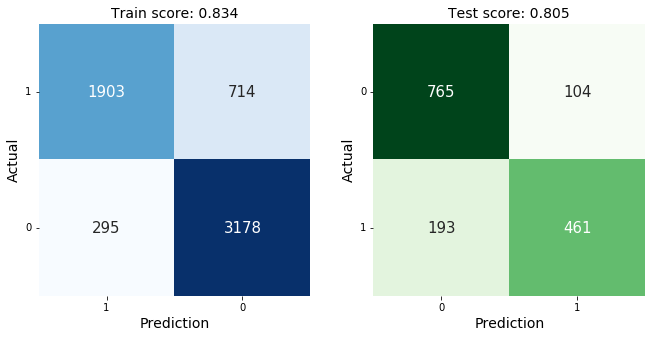

In [12]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [13]:
df_test = pd.read_csv('data/test_tweet.csv', index_col='id')

In [14]:
test_result = model.predict(df_test.text)

In [15]:
test_result

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [16]:
output = pd.DataFrame({'id': df_test.index,
                     'target': test_result})
output.to_csv('submission.csv', index=False)